### Model

In [83]:
import autograd.numpy as np
from autograd import grad
from autograd.misc.flatten import flatten

In [84]:
def relu(v):
    return np.maximum(0, v)
def sigmoid(val):
    return (1.0 / (1 + np.exp(-val)))

In [ ]:
def init_params(n_dense_features, d_embeddings = [], l_cn = 2, d_ff = 128, l_ff = 2):

    def mat(d_in, d_out):
        return np.random.randn(d_in, d_out) * np.sqrt(2.0 / d_in) / 3.0

    emb_layers = [mat(vocab_size, emb_sz) for vocab_size, emb_sz in d_embeddings]
    
    tot_emb_sz = sum(emb_sz for _, emb_sz in d_embeddings)
    d_cn = n_dense_features + tot_emb_sz

    # [[W, bias], ...]
    cn_layers = [[mat(d_cn, d_cn), np.zeros((d_cn, 1))] for _ in range(l_cn)]

    # [[W, bias], ...]
    ff_layers = [[mat(d_cn, d_ff), np.zeros((1, d_ff))]]
    ff_layers += [[mat(d_ff, d_ff), np.zeros((1, d_ff))] for _ in range(l_ff - 1)]

    # W
    W_output = mat(d_ff, 1)

    return {'emb': emb_layers, 'cn': cn_layers, 'ff': ff_layers, 'W_out': W_output}

def predict(params, x_dense, x_cat):
    assert len(x_cat) == len(params['emb'])

    embs = [emb[idx].T for emb, idx in zip(params['emb'], x_cat)]

    x0 = np.vstack([x_dense] + embs)
    x = x0
    # (d_cn, batch)
    
    for W, bias in params['cn']:
        x = x0 * (W @ x + bias) + x

    # sum G(j) * (U @ (L @ x) + bias) + x

    x = x.T
    for W, bias in params['ff']:
        x = relu(x @ W + bias)

    return x @ params['W_out'] # (batch, 1)

In [86]:
unflatten = None
def mse(flat_params, x_dense, x_cat, target):
    params = unflatten(flat_params)
    pred = predict(params, x_dense, x_cat)
    return np.mean((target - pred) ** 2)

def logloss(flat_params, x_dense, x_cat, target):
    params = unflatten(flat_params)
    pred = sigmoid(predict(params, x_dense, x_cat))
    pred = np.clip(pred, 1e-9, 1 - 1e-9)

    return -np.mean(target * np.log(pred) + (1 - target) * np.log(1 - pred))

# for CTR check, not used on training
from sklearn.metrics import roc_auc_score
def aucscore(flat_params, x_dense, x_cat, target):
    params = unflatten(flat_params)
    pred = sigmoid(predict(params, x_dense, x_cat))
    return roc_auc_score(target.flatten(), pred.flatten())

### Regression

In [87]:
input_len = 5
def f(x):
    return x[0] * x[1] + x[4]**2

def gen_sample(batch_size):
    x = np.random.randn(input_len, batch_size)
    y = f(x)
    return x, y.reshape(-1, 1)

np.random.seed(123)

gradient_fn = grad(mse)
learning_rate = 1e-5
batch_size = 10
num_iters = 20000

params = init_params(n_dense_features=input_len, d_embeddings=[], l_cn=3, d_ff=8, l_ff=2)
params, unflatten = flatten(params)

In [88]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, target = gen_sample(batch_size=batch_size)
    return mse(params, x_dense, [], target)
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss_val = objective(params, iter)
        print(f"Step: {iter:<5} | Loss: {loss_val:.6f}")

nw_params = adam(grad(objective), params, step_size=1e-3, num_iters=num_iters, callback=callback)
params = nw_params

callback(params, num_iters, None)

Step: 0     | Loss: 2.938775
Step: 500   | Loss: 0.384322
Step: 1000  | Loss: 0.708295
Step: 1500  | Loss: 1.737133
Step: 2000  | Loss: 0.247565
Step: 2500  | Loss: 0.714971
Step: 3000  | Loss: 0.138944
Step: 3500  | Loss: 0.183837
Step: 4000  | Loss: 0.204385
Step: 4500  | Loss: 0.508327
Step: 5000  | Loss: 0.532065
Step: 5500  | Loss: 0.131398
Step: 6000  | Loss: 0.050314
Step: 6500  | Loss: 0.060191
Step: 7000  | Loss: 0.028362
Step: 7500  | Loss: 0.059043
Step: 8000  | Loss: 0.032861
Step: 8500  | Loss: 0.037367
Step: 9000  | Loss: 0.076589
Step: 9500  | Loss: 0.034797
Step: 10000 | Loss: 0.052483
Step: 10500 | Loss: 0.019660
Step: 11000 | Loss: 0.009382
Step: 11500 | Loss: 0.009663
Step: 12000 | Loss: 0.010295
Step: 12500 | Loss: 0.002542
Step: 13000 | Loss: 0.017284
Step: 13500 | Loss: 0.006708
Step: 14000 | Loss: 0.034999
Step: 14500 | Loss: 0.018080
Step: 15000 | Loss: 0.005081
Step: 15500 | Loss: 0.002023
Step: 16000 | Loss: 0.004517
Step: 16500 | Loss: 0.007950
Step: 17000 | 

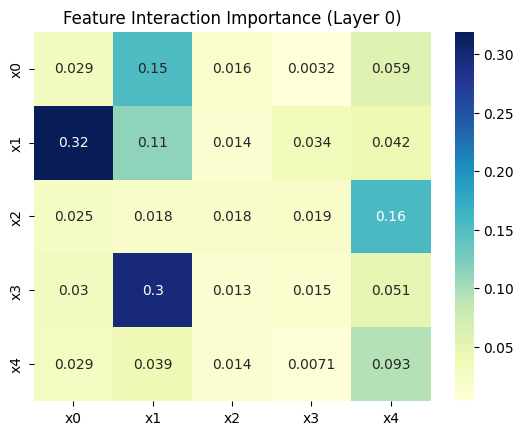

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_nice_heatmap(params, layer_idx=0):
    p = unflatten(params)
    mat = np.abs(p['cn'][layer_idx][0])
    
    # plt.figure(figsize=(6, 3))
    sns.heatmap(mat, annot=True, cmap="YlGnBu", 
                xticklabels=[f"x{i}" for i in range(len(mat))], 
                yticklabels=[f"x{i}" for i in range(len(mat))])
    
    plt.title(f"Feature Interaction Importance (Layer {layer_idx})")
    plt.show()

plot_nice_heatmap(params, 0)

### CTR

In [90]:
input_len = 5
def f(x):
    val = -3 + x[0] * x[1] + 3 * x[4]**2
    prob = sigmoid(val)
    return np.random.rand(*prob.shape) < prob

def gen_sample(batch_size = 1):
    x = np.random.randn(input_len, batch_size)
    y = f(x)
    return x, y.reshape(-1, 1)

np.random.seed(123)

gradient_fn = grad(logloss)
learning_rate = 1e-5
batch_size = 32
num_iters = 20000

params = init_params(n_dense_features=5, d_embeddings=[], l_cn=2, d_ff=8, l_ff=2)
params, unflatten = flatten(params)

In [91]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, target = gen_sample(batch_size=batch_size)
    return logloss(params, x_dense, [], target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss_val = objective(params, iter)

        x_dense, target = gen_sample(batch_size=1000)
        auc = aucscore(params, x_dense, [], target)
        
        print(f"Step: {iter:<5} | LogLoss: {loss_val:.6f} | AUC: {auc}")

nw_params = adam(grad(objective), params, step_size=1e-3, num_iters=num_iters, callback=callback)
params = nw_params

callback(params, num_iters, None)

Step: 0     | LogLoss: 0.693102 | AUC: 0.4812690013102158
Step: 500   | LogLoss: 0.437579 | AUC: 0.836686145730982
Step: 1000  | LogLoss: 0.211070 | AUC: 0.894626224231217
Step: 1500  | LogLoss: 0.216732 | AUC: 0.9046675362900529
Step: 2000  | LogLoss: 0.397907 | AUC: 0.9337825590762621
Step: 2500  | LogLoss: 0.219780 | AUC: 0.9173561397951642
Step: 3000  | LogLoss: 0.424383 | AUC: 0.9193642301395757
Step: 3500  | LogLoss: 0.217291 | AUC: 0.9164722827680267
Step: 4000  | LogLoss: 0.321005 | AUC: 0.9338083333333334
Step: 4500  | LogLoss: 0.183562 | AUC: 0.9079179555754917
Step: 5000  | LogLoss: 0.258692 | AUC: 0.9140557512127051
Step: 5500  | LogLoss: 0.332983 | AUC: 0.9212588956317456
Step: 6000  | LogLoss: 0.384261 | AUC: 0.914218100469123
Step: 6500  | LogLoss: 0.317960 | AUC: 0.9275684880980984
Step: 7000  | LogLoss: 0.414176 | AUC: 0.9306201960369508
Step: 7500  | LogLoss: 0.225701 | AUC: 0.9187720864720752
Step: 8000  | LogLoss: 0.240792 | AUC: 0.9263447280688659
Step: 8500  | Log

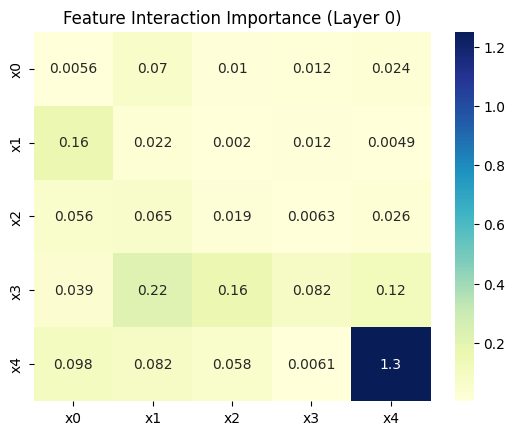

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_nice_heatmap(params, layer_idx=0):
    p = unflatten(params)
    mat = np.abs(p['cn'][layer_idx][0])
    
    sns.heatmap(mat, annot=True, cmap="YlGnBu", 
                xticklabels=[f"x{i}" for i in range(len(mat))], 
                yticklabels=[f"x{i}" for i in range(len(mat))])
    
    plt.title(f"Feature Interaction Importance (Layer {layer_idx})")
    plt.show()

plot_nice_heatmap(params, 0)

### MovieLens

In [93]:
import pandas as pd

df_ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
df_users = pd.read_csv('u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

df = pd.merge(df_ratings, df_users, on='user_id')

# df = df.sample(frac=1).reset_index(drop=True) # shuffle

In [94]:
d_embeddings = []

df['age'] = df['age'] / 100.0

df['liked'] = (df['rating'] > 3.0).astype(int)

cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']

for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes

In [95]:
print(df)

       user_id  item_id  rating  timestamp   age  gender  occupation  \
0          195      241       3  881250949  0.49       1          20   
1          185      301       3  891717742  0.39       0           6   
2           21      376       1  878887116  0.25       1          20   
3          243       50       2  880606923  0.28       1          19   
4          165      345       1  886397596  0.47       1           3   
...        ...      ...     ...        ...   ...     ...         ...   
99995      879      475       3  880175444  0.13       1          18   
99996      715      203       5  879795543  0.36       0           0   
99997      275     1089       1  874795795  0.21       1          18   
99998       12      224       2  882399156  0.47       1           3   
99999       11      202       3  879959583  0.28       0          13   

       zip_code  liked  
0           415      0  
1             0      0  
2           311      0  
3           591      0  
4         

In [96]:
cat_cols = ['user_id', 'item_id', 'gender', 'occupation', 'zip_code']
dense_cols = ['age']
n_dense_features = len(dense_cols)

d_embeddings = []
for col in cat_cols:
    vocab_size = df[col].nunique()
    emb_size = int((vocab_size ** (1.0/4.0)) * 6)
    d_embeddings.append((vocab_size, emb_size))
    
print(f"Cat Cols: {cat_cols + ['age_bucket']}")
print(f"Embedding Sizes: {d_embeddings}")

Cat Cols: ['user_id', 'item_id', 'gender', 'occupation', 'zip_code', 'age_bucket']
Embedding Sizes: [(943, 33), (1682, 38), (2, 7), (21, 12), (795, 31)]


In [97]:
def gen_sample(batch_size = 1):
    idx = np.random.randint(0, len(df), size = (batch_size))
    batch = df.iloc[idx]
    x_cat = np.array(batch[cat_cols].values.T)
    x_dense = np.array(batch[dense_cols].values.T)
    y = np.array(batch['liked'].values).reshape(-1, 1)
    return x_dense, x_cat, y

np.random.seed(123)

gradient_fn = grad(logloss)
learning_rate = 1e-5
batch_size = 32
num_iters = 20000

params = init_params(n_dense_features=n_dense_features, d_embeddings=d_embeddings, l_cn=2, d_ff=8, l_ff=2)
params, unflatten = flatten(params)

In [98]:
from autograd.misc.optimizers import adam
def objective(params, iter):
    x_dense, x_cat, target = gen_sample(batch_size=batch_size)
    return logloss(params, x_dense, x_cat, target)
    
def callback(params, iter, gradient):
    if iter % 500 == 0:
        loss_val = objective(params, iter)

        x_dense, x_cat, target = gen_sample(batch_size=1000)
        auc = aucscore(params, x_dense, x_cat, target)
        
        print(f"Step: {iter:<5} | LogLoss: {loss_val:.6f} | AUC: {auc:.6f}")

nw_params = adam(grad(objective), params, step_size=1e-3, num_iters=num_iters, callback=callback)
params = nw_params

callback(params, num_iters, None)

Step: 0     | LogLoss: 0.692849 | AUC: 0.491371
Step: 500   | LogLoss: 0.578105 | AUC: 0.763601
Step: 1000  | LogLoss: 0.591532 | AUC: 0.742653
Step: 1500  | LogLoss: 0.430692 | AUC: 0.778320
Step: 2000  | LogLoss: 0.577092 | AUC: 0.782693
Step: 2500  | LogLoss: 0.594356 | AUC: 0.767340
Step: 3000  | LogLoss: 0.491143 | AUC: 0.759476
Step: 3500  | LogLoss: 0.598238 | AUC: 0.786262
Step: 4000  | LogLoss: 0.437377 | AUC: 0.822389
Step: 4500  | LogLoss: 0.609376 | AUC: 0.777767
Step: 5000  | LogLoss: 0.516307 | AUC: 0.796777
Step: 5500  | LogLoss: 0.626620 | AUC: 0.792366
Step: 6000  | LogLoss: 0.515253 | AUC: 0.788214
Step: 6500  | LogLoss: 0.772356 | AUC: 0.813688
Step: 7000  | LogLoss: 0.484199 | AUC: 0.800047
Step: 7500  | LogLoss: 0.582571 | AUC: 0.801041
Step: 8000  | LogLoss: 0.500991 | AUC: 0.815105
Step: 8500  | LogLoss: 0.360980 | AUC: 0.818068
Step: 9000  | LogLoss: 0.541453 | AUC: 0.814696
Step: 9500  | LogLoss: 0.629639 | AUC: 0.832842
Step: 10000 | LogLoss: 0.396973 | AUC: 0

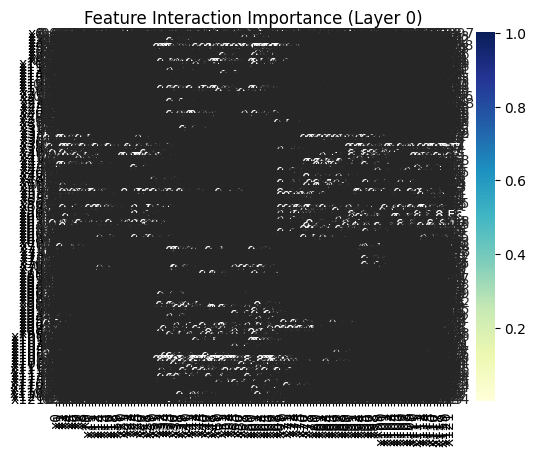

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_nice_heatmap(params, layer_idx=0):
    p = unflatten(params)
    mat = np.abs(p['cn'][layer_idx][0])
    
    sns.heatmap(mat, annot=True, cmap="YlGnBu", 
                xticklabels=[f"x{i}" for i in range(len(mat))], 
                yticklabels=[f"x{i}" for i in range(len(mat))])
    
    plt.title(f"Feature Interaction Importance (Layer {layer_idx})")
    plt.show()

plot_nice_heatmap(params, 0)